# NN by pytorch

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch.utils.tensorboard import SummaryWriter

In [3]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


## Data Loading

In [15]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/NN_tuned")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")


from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import dict_act, NN, train_NN, count_parameters


saved in: /Users/chen-mac/Library/CloudStorage/OneDrive-UTCloud/PhD/Papers/Deep Learning based Position Detection for Hydraulic Cylinders using Scattering Parameters/RBI/models/NN_tuned


## Data Extraction

In [6]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [7]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 242)
(411257,)
(102815, 242)
(102815,)


### Normalization

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X)
X_train_scaled = X_scaled[idx_train]
X_test_scaled = X_scaled[idx_test]
X_TEST_scaled = scaler.transform(X_TEST)

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 242)
(411257, 1)
(102815, 242)
(102815, 1)
(20135, 242)
(20135, 1)


## NN with tanh

### Init

In [10]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "tanh",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001, 
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8417


In [17]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [18]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )

model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [19]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [20]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
    save=False,
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:0.4f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1049.12, test loss : 1024.82, TEST loss : 1019.90, lr: 0.0010
epoch : 10, train loss : 630.46, test loss : 612.20, TEST loss : 607.59, lr: 0.0010
epoch : 20, train loss : 296.23, test loss : 281.75, TEST loss : 278.21, lr: 0.0010
epoch : 30, train loss : 68.15, test loss : 58.02, TEST loss : 56.30, lr: 0.0010
epoch : 40, train loss : 17.22, test loss : 10.05, TEST loss : 11.19, lr: 0.0010
epoch : 50, train loss : 13.65, test loss : 7.89, TEST loss : 9.39, lr: 0.0010
epoch : 60, train loss : 12.18, test loss : 7.44, TEST loss : 9.24, lr: 0.0010
epoch : 70, train loss : 11.40, test loss : 6.29, TEST loss : 7.73, lr: 0.0010
epoch : 80, train loss : 10.83, test loss : 6.24, TEST loss : 7.87, lr: 0.0010
epoch : 90, train loss : 10.27, test loss : 5.36, TEST loss : 7.19, lr: 0.0010
epoch : 100, train loss : 10.04, test loss : 5.72, TEST loss : 7.43, lr: 0.0010
epoch : 110, train loss : 9.82, test loss : 5.74, TEST loss : 7.56, lr: 0.0010
epoch : 120, train loss : 9.43

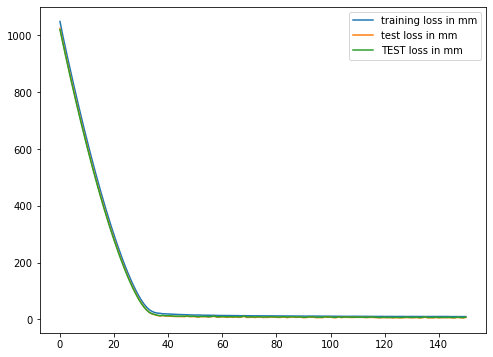

In [20]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [16]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()

NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [17]:
# evaluation on  training, test and TEST set on 3090

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
t1 = time.perf_counter()
y_test_ = y_[idx_test]
t2 = time.perf_counter()


RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")
print()
print(f"average inference time {(t2-t1)/idx_test.shape[0]*1000:.10f} ms")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 3.54 mm
test RMSE: 3.54 mm
TEST RMSE: 6.19 mm

average inference time 0.0000093801 ms


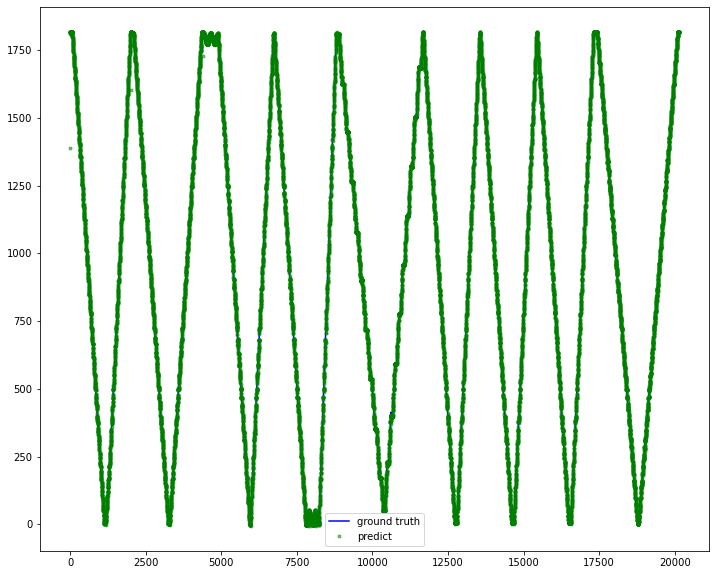

In [23]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


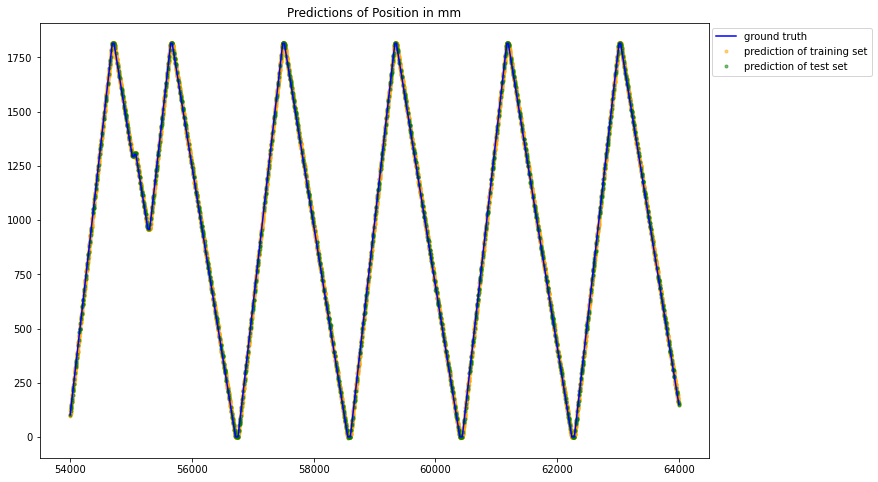

In [24]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with sigmoid

### Init

In [25]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": True,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_sigmoid.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_sigmoid.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8417


In [26]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [27]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [28]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [29]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.04, test loss : 1030.83, TEST loss : 1025.96, lr: 0.0010
epoch : 10, train loss : 635.16, test loss : 616.91, TEST loss : 612.28, lr: 0.0010
epoch : 20, train loss : 299.85, test loss : 285.54, TEST loss : 281.89, lr: 0.0010
epoch : 30, train loss : 71.66, test loss : 63.06, TEST loss : 60.28, lr: 0.0010
epoch : 40, train loss : 22.39, test loss : 20.12, TEST loss : 18.34, lr: 0.0010
epoch : 50, train loss : 15.09, test loss : 13.43, TEST loss : 12.11, lr: 0.0010
epoch : 60, train loss : 10.40, test loss : 8.51, TEST loss : 7.92, lr: 0.0010
epoch : 70, train loss : 7.77, test loss : 6.33, TEST loss : 6.64, lr: 0.0010
epoch : 80, train loss : 6.45, test loss : 4.72, TEST loss : 5.62, lr: 0.0010
epoch : 90, train loss : 5.96, test loss : 3.67, TEST loss : 4.87, lr: 0.0010
epoch : 100, train loss : 5.44, test loss : 4.21, TEST loss : 5.26, lr: 0.0010
epoch : 110, train loss : 5.03, test loss : 2.91, TEST loss : 4.09, lr: 0.0010
epoch : 120, train loss : 4.96, 

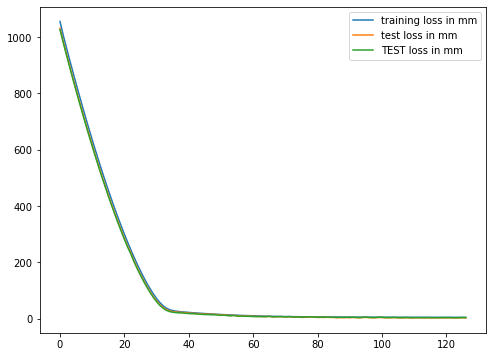

In [30]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [31]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [32]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

train RMSE: 2.71 mm
test RMSE: 2.73 mm
TEST RMSE: 3.89 mm


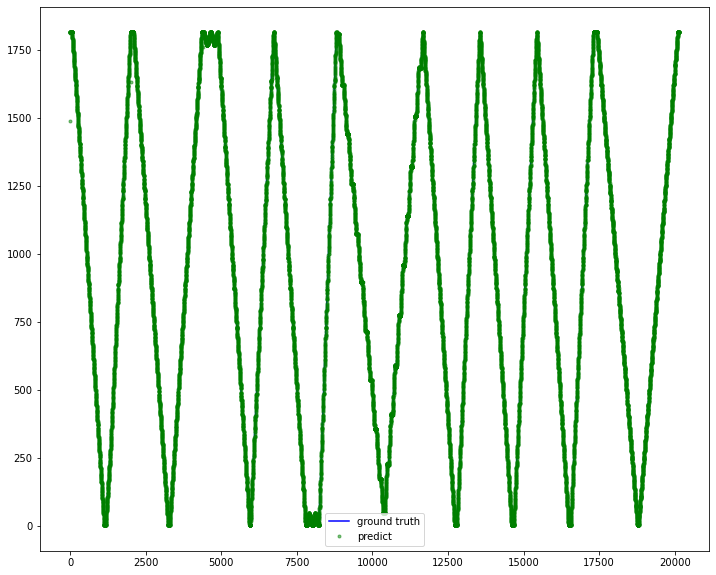

In [33]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


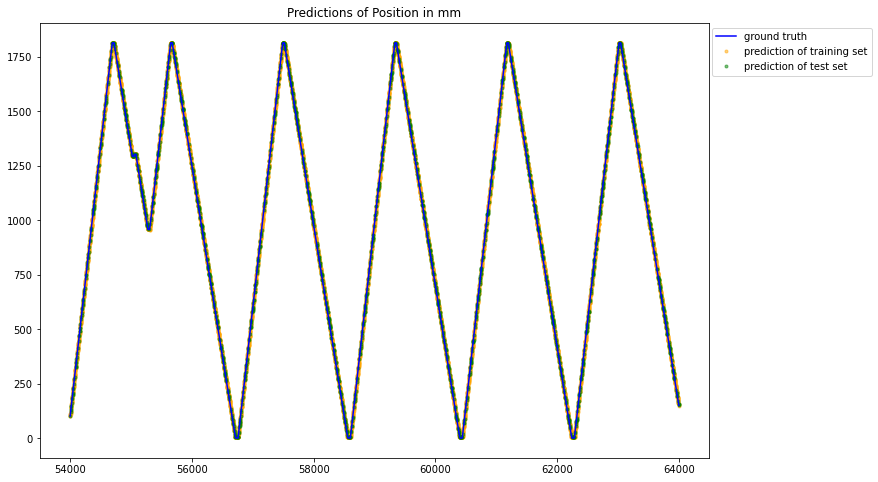

In [34]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with SeLU

### Init

In [35]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "selu",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_selu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_selu.pth
NN(
  (activation): SELU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8417


In [36]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [37]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [38]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [39]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 967.18, test loss : 787.78, TEST loss : 785.68, lr: 0.0010
epoch : 10, train loss : 36.92, test loss : 13.40, TEST loss : 16.01, lr: 0.0010
epoch : 20, train loss : 22.68, test loss : 11.14, TEST loss : 14.59, lr: 0.0010
epoch : 30, train loss : 17.99, test loss : 7.42, TEST loss : 9.34, lr: 0.0010
epoch : 40, train loss : 15.51, test loss : 8.16, TEST loss : 9.53, lr: 0.0010
epoch : 50, train loss : 13.76, test loss : 6.65, TEST loss : 7.93, lr: 0.0010
epoch : 60, train loss : 13.05, test loss : 7.65, TEST loss : 8.30, lr: 0.0010
epoch : 70, train loss : 12.28, test loss : 6.03, TEST loss : 7.20, lr: 0.0010
epoch : 80, train loss : 11.56, test loss : 6.21, TEST loss : 7.22, lr: 0.0010
epoch : 90, train loss : 11.01, test loss : 5.44, TEST loss : 6.32, lr: 0.0010
epoch : 100, train loss : 10.41, test loss : 5.08, TEST loss : 6.00, lr: 0.0010
Early stopping triggered
The minimal test loss is 4.83 from epoch 87


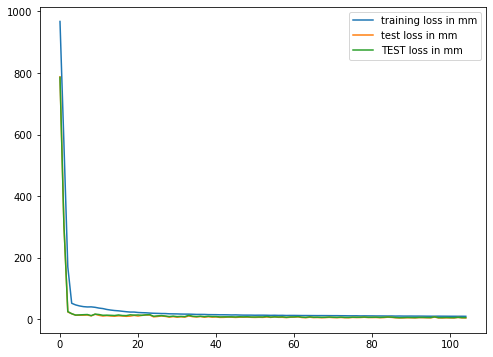

In [40]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [41]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): SELU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [42]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 4.84 mm
test RMSE: 4.86 mm
TEST RMSE: 5.88 mm


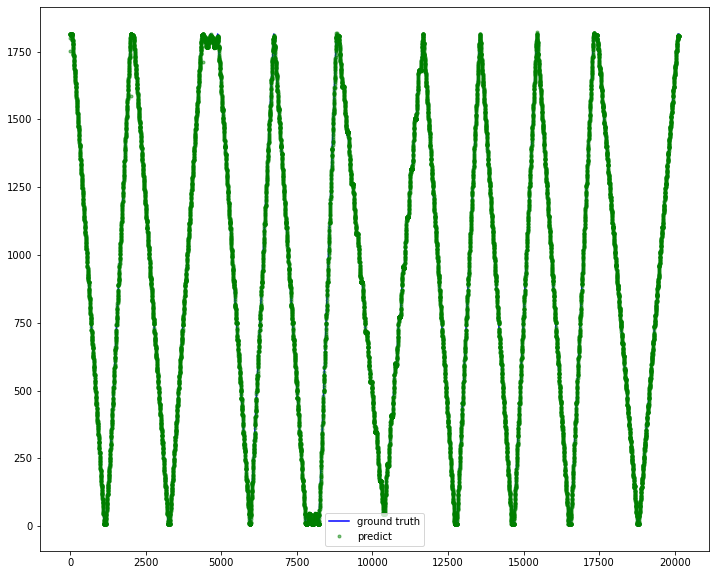

In [43]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


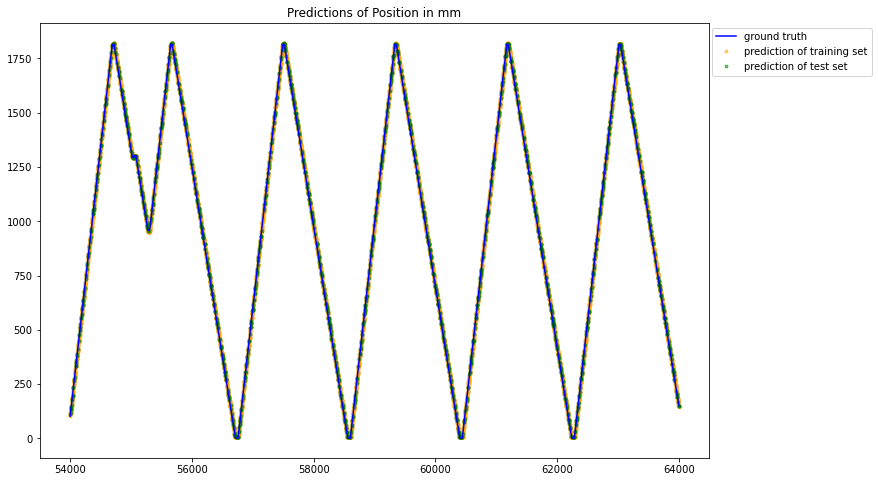

In [44]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with ReLU

### Init

In [45]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "relu",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_relu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_relu.pth
NN(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8417


In [46]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [47]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [48]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [49]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 956.71, test loss : 735.77, TEST loss : 731.70, lr: 0.0010
epoch : 10, train loss : 31.07, test loss : 9.74, TEST loss : 12.49, lr: 0.0010
epoch : 20, train loss : 21.98, test loss : 9.48, TEST loss : 11.50, lr: 0.0010
epoch : 30, train loss : 17.61, test loss : 7.91, TEST loss : 8.72, lr: 0.0010
epoch : 40, train loss : 15.29, test loss : 6.61, TEST loss : 8.19, lr: 0.0010
epoch : 50, train loss : 13.91, test loss : 5.65, TEST loss : 7.35, lr: 0.0010
epoch : 60, train loss : 12.80, test loss : 5.64, TEST loss : 7.42, lr: 0.0010
epoch : 70, train loss : 12.21, test loss : 5.29, TEST loss : 6.84, lr: 0.0010
epoch : 80, train loss : 11.58, test loss : 6.16, TEST loss : 7.59, lr: 0.0010
epoch : 90, train loss : 11.18, test loss : 4.54, TEST loss : 6.85, lr: 0.0010
epoch : 100, train loss : 11.00, test loss : 5.34, TEST loss : 7.00, lr: 0.0010
Early stopping triggered
The minimal test loss is 4.31 from epoch 87


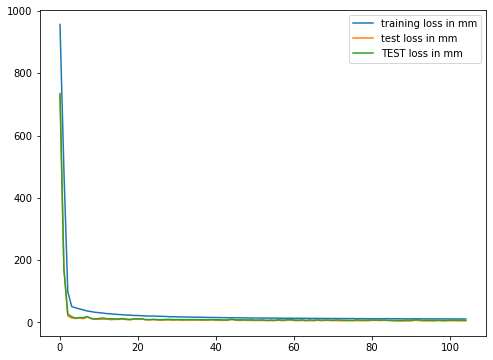

In [50]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [51]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [52]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 4.26 mm
test RMSE: 4.30 mm
TEST RMSE: 5.96 mm


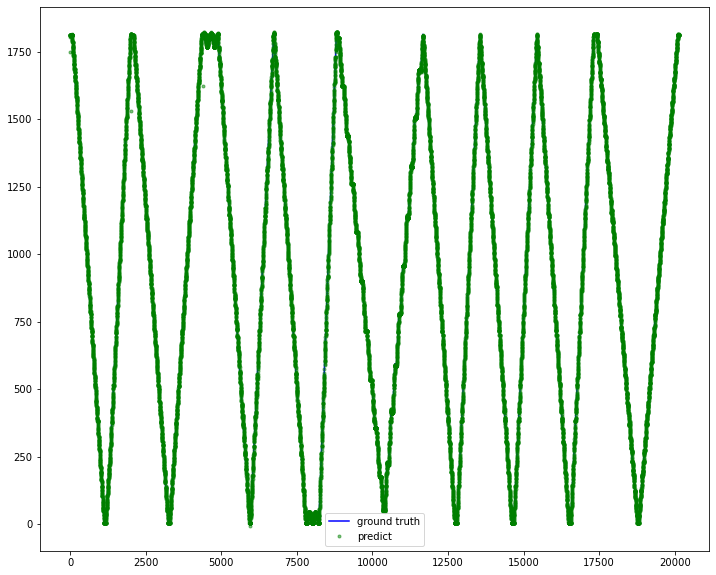

In [53]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


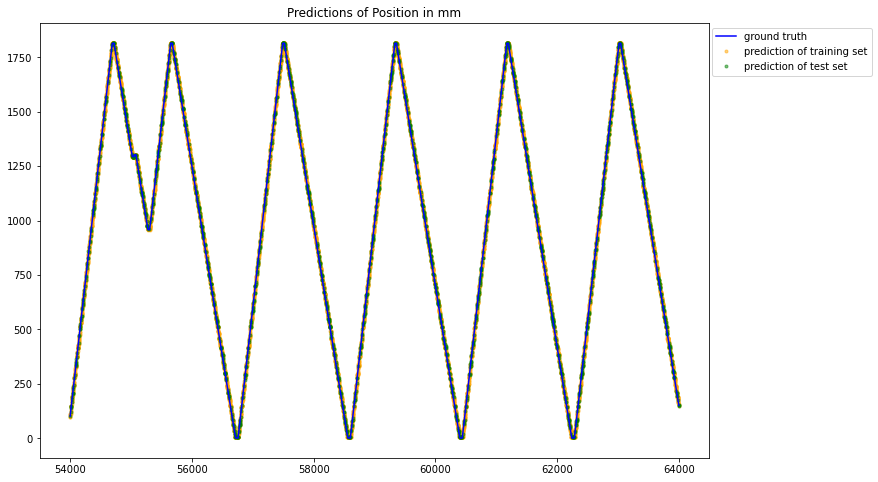

In [54]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with LeakyReLU(0.2)

### Init

In [55]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "tanh",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_leakyrelu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_leakyrelu.pth
NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8417


In [56]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [57]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [58]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [59]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1049.01, test loss : 1024.73, TEST loss : 1019.81, lr: 0.0010
epoch : 10, train loss : 630.45, test loss : 612.22, TEST loss : 607.61, lr: 0.0010
epoch : 20, train loss : 296.15, test loss : 281.72, TEST loss : 278.20, lr: 0.0010
epoch : 30, train loss : 67.43, test loss : 57.54, TEST loss : 55.90, lr: 0.0010
epoch : 40, train loss : 16.58, test loss : 11.59, TEST loss : 13.24, lr: 0.0010
epoch : 50, train loss : 13.23, test loss : 10.91, TEST loss : 12.25, lr: 0.0010
epoch : 60, train loss : 11.90, test loss : 7.36, TEST loss : 9.62, lr: 0.0010
epoch : 70, train loss : 11.04, test loss : 6.31, TEST loss : 9.01, lr: 0.0010
Early stopping triggered
The minimal test loss is 5.60 from epoch 63


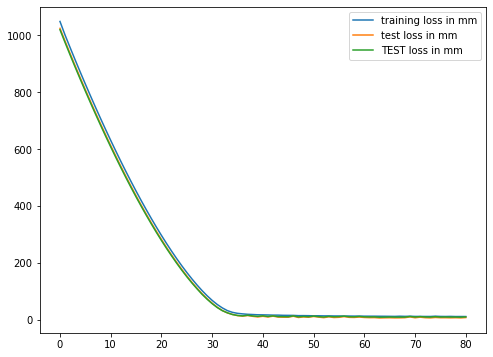

In [60]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [61]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [62]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 5.58 mm
test RMSE: 5.60 mm
TEST RMSE: 8.30 mm


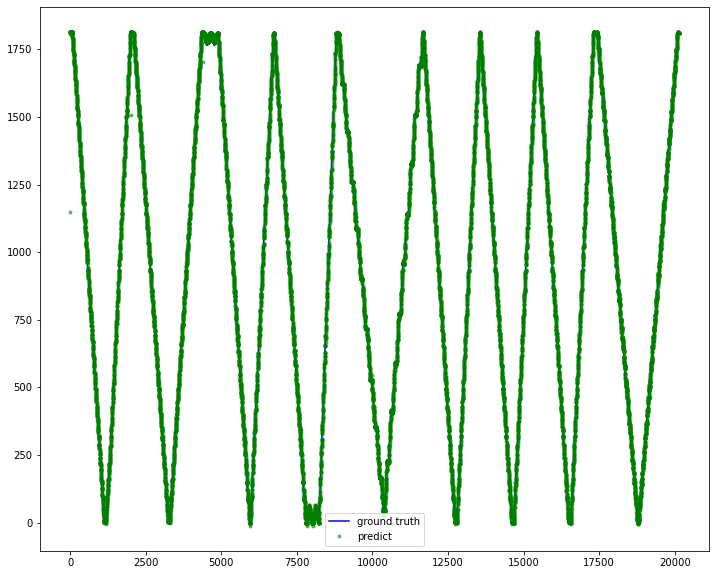

In [63]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


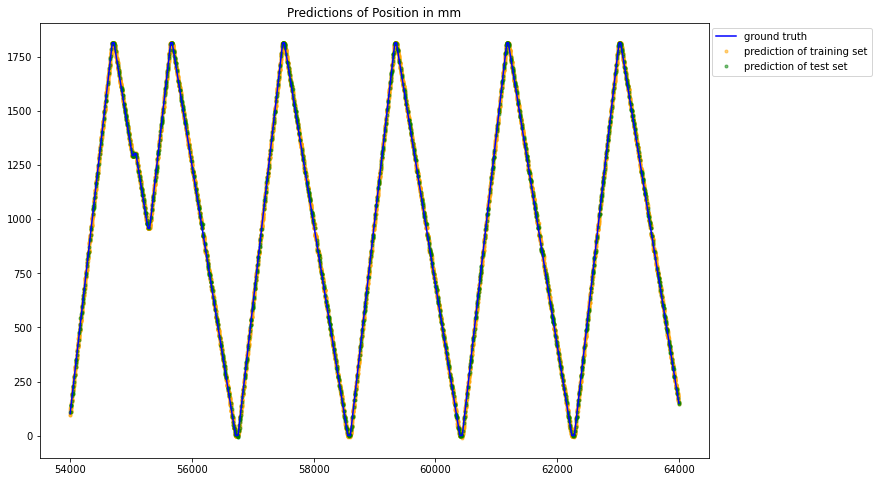

In [64]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 1 layer

### Init

In [65]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
number of learning parameters: 7873


In [66]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [67]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )

model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [68]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [69]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1032.35, test loss : 985.03, TEST loss : 979.96, lr: 0.0010
epoch : 10, train loss : 316.44, test loss : 289.41, TEST loss : 287.33, lr: 0.0010
epoch : 20, train loss : 85.09, test loss : 77.82, TEST loss : 85.06, lr: 0.0010
epoch : 30, train loss : 67.61, test loss : 60.61, TEST loss : 71.47, lr: 0.0010
epoch : 40, train loss : 53.38, test loss : 47.53, TEST loss : 55.37, lr: 0.0010
epoch : 50, train loss : 41.53, test loss : 36.49, TEST loss : 43.84, lr: 0.0010
epoch : 60, train loss : 36.46, test loss : 30.86, TEST loss : 36.48, lr: 0.0010
epoch : 70, train loss : 33.20, test loss : 27.94, TEST loss : 33.02, lr: 0.0010
epoch : 80, train loss : 30.60, test loss : 24.99, TEST loss : 29.15, lr: 0.0010
epoch : 90, train loss : 28.83, test loss : 23.21, TEST loss : 27.17, lr: 0.0010
epoch : 100, train loss : 27.33, test loss : 22.35, TEST loss : 25.15, lr: 0.0010
epoch : 110, train loss : 26.52, test loss : 21.28, TEST loss : 24.85, lr: 0.0010
epoch : 120, train l

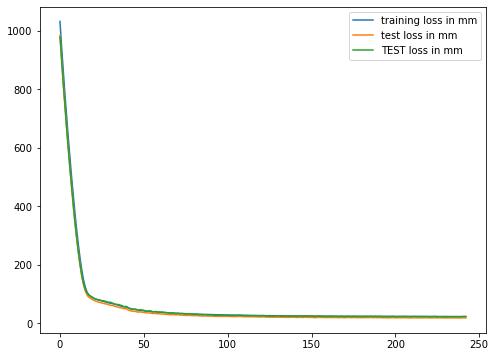

In [70]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [71]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [72]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 16.81 mm
test RMSE: 17.13 mm
TEST RMSE: 20.47 mm


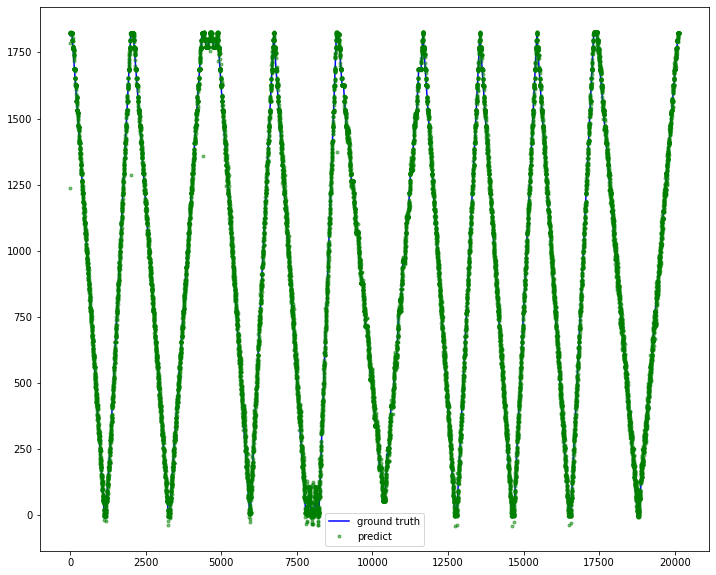

In [73]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


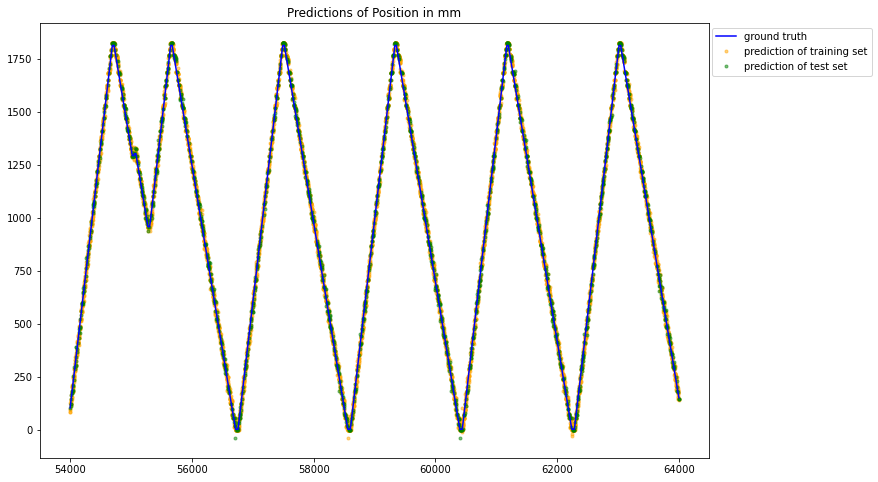

In [74]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 3 layer

### Init

In [75]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 9537


In [76]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [77]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [78]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [79]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.92, test loss : 1031.44, TEST loss : 1026.57, lr: 0.0010
epoch : 10, train loss : 635.53, test loss : 617.26, TEST loss : 612.63, lr: 0.0010
epoch : 20, train loss : 300.06, test loss : 285.70, TEST loss : 282.05, lr: 0.0010
epoch : 30, train loss : 70.10, test loss : 61.75, TEST loss : 58.92, lr: 0.0010
epoch : 40, train loss : 19.55, test loss : 19.15, TEST loss : 16.99, lr: 0.0010
epoch : 50, train loss : 12.58, test loss : 11.66, TEST loss : 10.04, lr: 0.0010
epoch : 60, train loss : 7.89, test loss : 7.12, TEST loss : 6.53, lr: 0.0010
epoch : 70, train loss : 5.30, test loss : 11.64, TEST loss : 12.36, lr: 0.0010
epoch : 80, train loss : 4.32, test loss : 3.54, TEST loss : 5.06, lr: 0.0010
epoch : 90, train loss : 3.75, test loss : 4.28, TEST loss : 5.42, lr: 0.0010
epoch : 100, train loss : 3.67, test loss : 2.85, TEST loss : 4.47, lr: 0.0010
Early stopping triggered
The minimal test loss is 2.64 from epoch 91


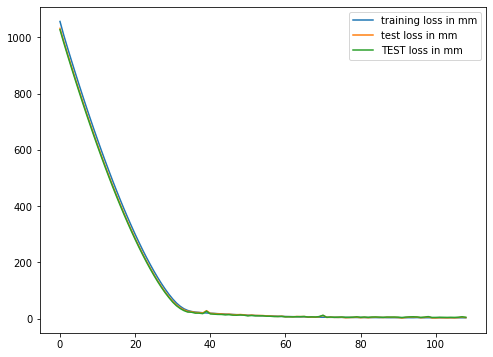

In [80]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [81]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [82]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.69 mm
test RMSE: 2.70 mm
TEST RMSE: 4.23 mm


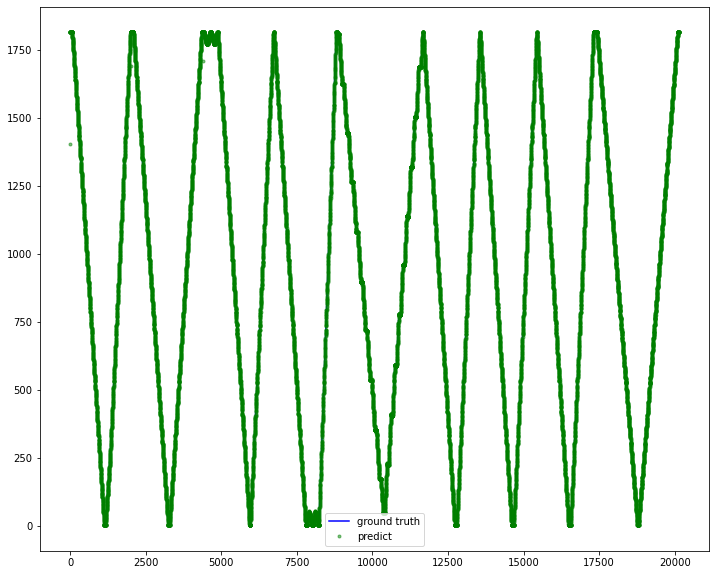

In [83]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


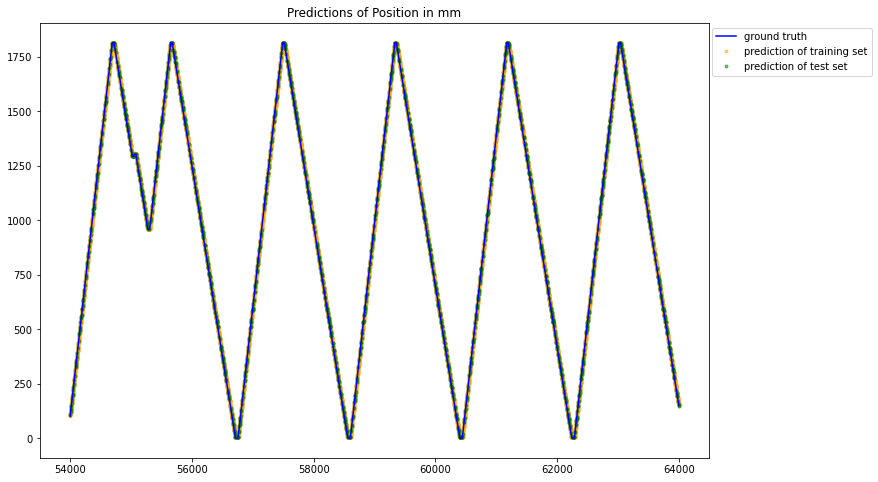

In [84]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 4 layer

### Init

In [105]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 10657


In [106]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [107]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [108]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [109]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1052.67, test loss : 1028.80, TEST loss : 1023.94, lr: 0.0010
epoch : 10, train loss : 633.52, test loss : 615.27, TEST loss : 610.64, lr: 0.0010
epoch : 20, train loss : 298.50, test loss : 284.20, TEST loss : 280.59, lr: 0.0010
epoch : 30, train loss : 68.80, test loss : 60.64, TEST loss : 57.84, lr: 0.0010
epoch : 40, train loss : 18.51, test loss : 18.03, TEST loss : 15.59, lr: 0.0010
epoch : 50, train loss : 11.36, test loss : 10.82, TEST loss : 9.03, lr: 0.0010
epoch : 60, train loss : 6.29, test loss : 5.27, TEST loss : 4.38, lr: 0.0010
epoch : 70, train loss : 3.35, test loss : 2.86, TEST loss : 2.85, lr: 0.0010
epoch : 80, train loss : 2.76, test loss : 2.50, TEST loss : 3.31, lr: 0.0010
epoch : 90, train loss : 2.43, test loss : 1.49, TEST loss : 1.86, lr: 0.0010
epoch : 100, train loss : 2.31, test loss : 1.64, TEST loss : 1.94, lr: 0.0010
epoch : 110, train loss : 2.20, test loss : 1.86, TEST loss : 2.22, lr: 0.0010
epoch : 120, train loss : 2.05, te

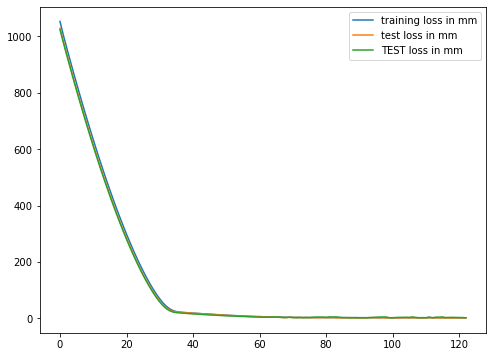

In [110]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [111]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [112]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.29 mm
test RMSE: 1.29 mm
TEST RMSE: 3.34 mm


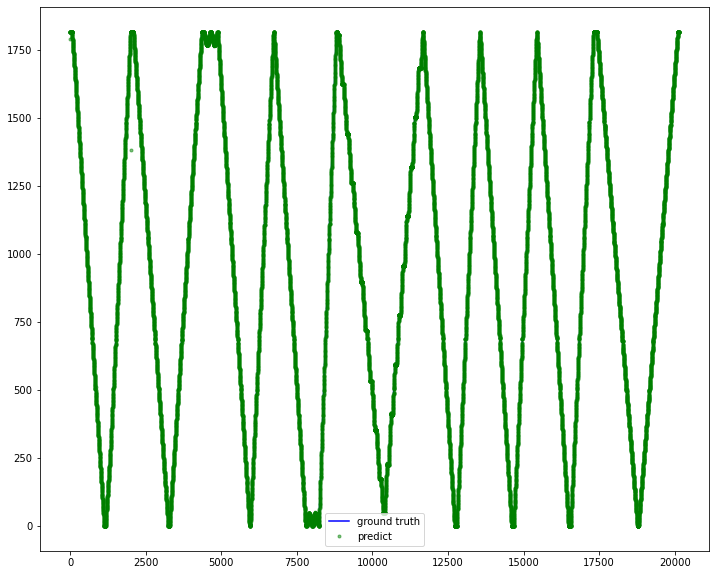

In [113]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


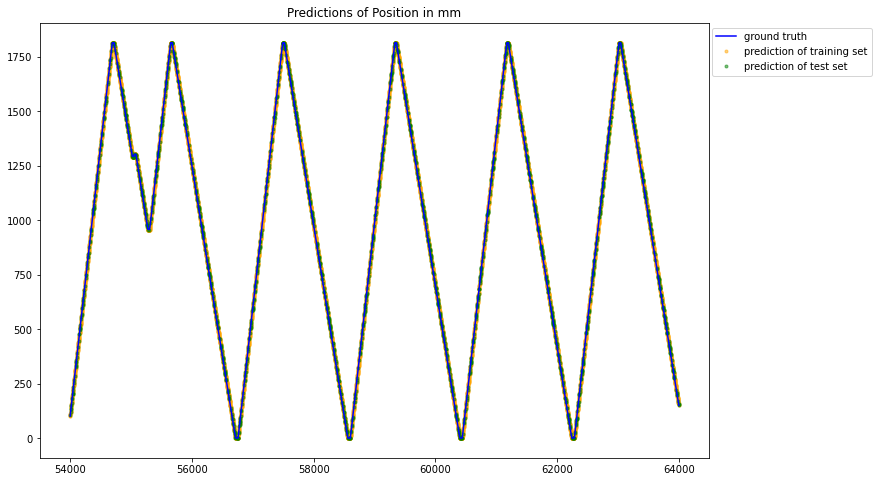

In [114]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 5 layer

### Init

In [125]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of le

In [126]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [127]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [128]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [129]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1056.04, test loss : 1031.40, TEST loss : 1026.53, lr: 0.0010
epoch : 10, train loss : 635.60, test loss : 617.41, TEST loss : 612.76, lr: 0.0010
epoch : 20, train loss : 300.02, test loss : 285.69, TEST loss : 282.03, lr: 0.0010
epoch : 30, train loss : 69.30, test loss : 61.14, TEST loss : 58.72, lr: 0.0010
epoch : 40, train loss : 18.99, test loss : 18.19, TEST loss : 17.55, lr: 0.0010
epoch : 50, train loss : 11.99, test loss : 11.16, TEST loss : 11.45, lr: 0.0010
epoch : 60, train loss : 6.53, test loss : 5.98, TEST loss : 7.53, lr: 0.0010
epoch : 70, train loss : 3.49, test loss : 4.08, TEST loss : 4.40, lr: 0.0010
epoch : 80, train loss : 2.86, test loss : 3.05, TEST loss : 3.93, lr: 0.0010
epoch : 90, train loss : 2.51, test loss : 2.19, TEST loss : 4.40, lr: 0.0010
epoch : 100, train loss : 2.35, test loss : 4.26, TEST loss : 4.41, lr: 0.0010
epoch : 110, train loss : 2.18, test loss : 1.63, TEST loss : 2.10, lr: 0.0010
epoch : 120, train loss : 2.22, t

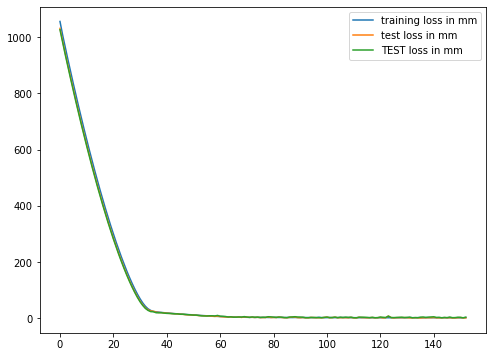

In [130]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [131]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [132]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.19 mm
test RMSE: 1.18 mm
TEST RMSE: 4.09 mm


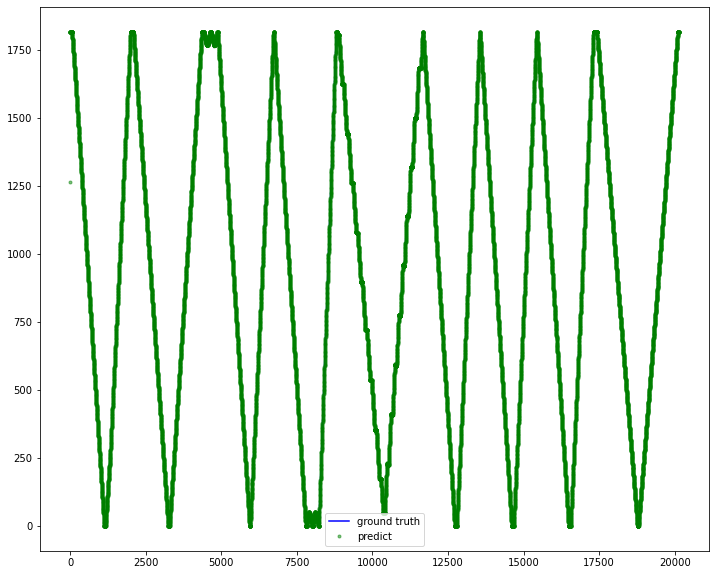

In [133]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


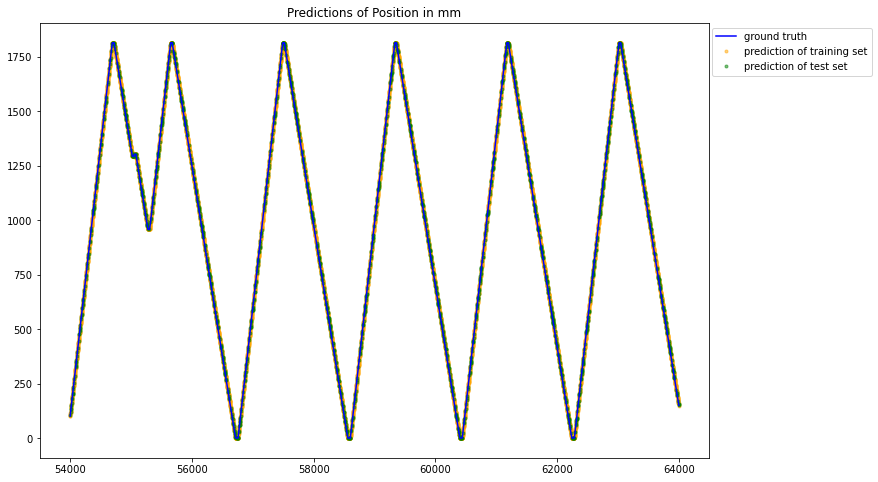

In [134]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 6 layer

### Init

In [27]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32,32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  "use_dropout":False, "use_bn":True,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): Linear(in_features=32, out_features=16, bias=True)
    (16): Batc

In [28]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [29]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [30]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [31]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.80, test loss : 1031.46, TEST loss : 1026.60, lr: 0.0010
epoch : 10, train loss : 635.57, test loss : 617.30, TEST loss : 612.67, lr: 0.0010
epoch : 20, train loss : 300.01, test loss : 286.06, TEST loss : 282.41, lr: 0.0010
epoch : 30, train loss : 69.40, test loss : 62.58, TEST loss : 60.16, lr: 0.0010
epoch : 40, train loss : 18.54, test loss : 18.25, TEST loss : 16.87, lr: 0.0010
epoch : 50, train loss : 11.23, test loss : 11.01, TEST loss : 10.23, lr: 0.0010
epoch : 60, train loss : 6.04, test loss : 5.86, TEST loss : 8.45, lr: 0.0010
epoch : 70, train loss : 3.19, test loss : 3.49, TEST loss : 8.07, lr: 0.0010
epoch : 80, train loss : 2.76, test loss : 2.43, TEST loss : 6.10, lr: 0.0010
epoch : 90, train loss : 2.32, test loss : 2.34, TEST loss : 4.11, lr: 0.0010
epoch : 100, train loss : 2.15, test loss : 2.87, TEST loss : 6.86, lr: 0.0010
epoch : 110, train loss : 1.99, test loss : 1.68, TEST loss : 2.74, lr: 0.0010
epoch : 120, train loss : 1.90, t

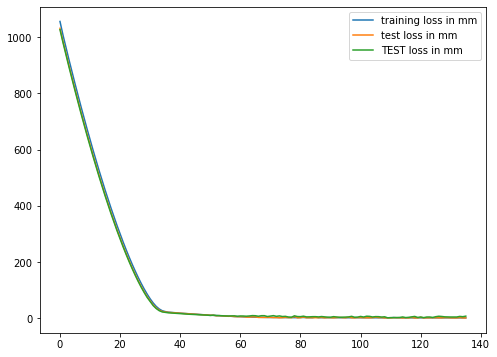

In [32]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [33]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): Linear(in_features=32, out_features=16, bias=True)
    (16): BatchNorm1d(16, eps=1e-05, mo

In [34]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.25 mm
test RMSE: 1.23 mm
TEST RMSE: 6.81 mm


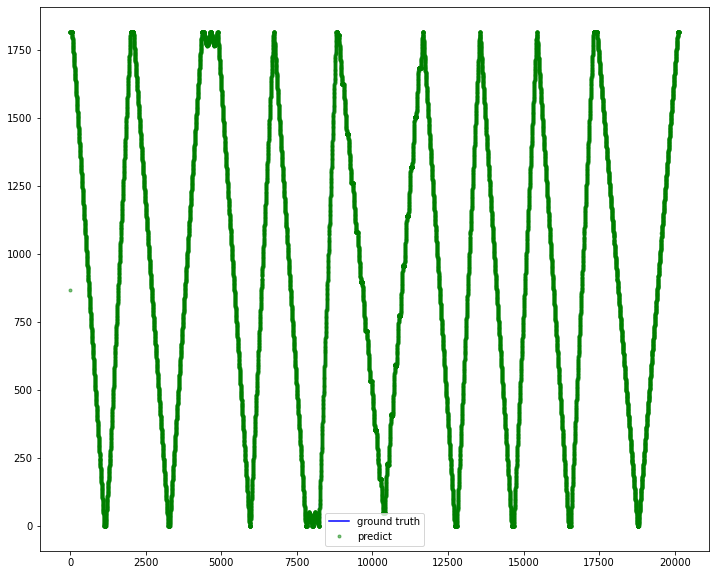

In [35]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


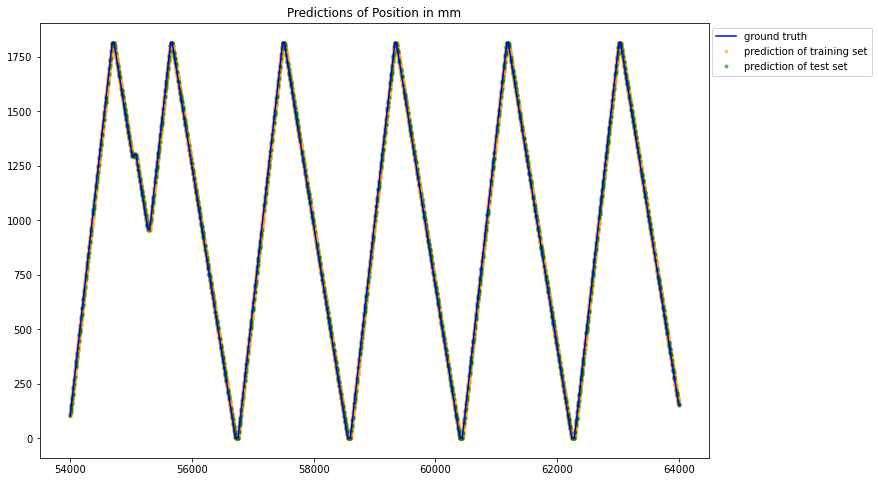

In [36]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
